In [1]:
import sys
sys.path.append('/work/ka1176/caroline/gitlab/icon-aes/externals/mlbridges/cffi_interface/')
sys.path.append('/work/ka1176/caroline/gitlab/icon-aes/externals/mlbridges/lib/')

#import cffi_plugin

#from cffi_plugin import ffi
import numpy as np
import os

import transfer_arrays
import copy

In [2]:
import torch
torch.cuda.is_available()

/home/k/k202141/.conda/envs/iconml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


False

In [3]:
from solvers.moment_solver import simulation_forecast

import models.plModel as plm

# initialization code
# TODO execute this in the load_pretrained_model function
inputs_mean = np.asarray([[0.0002621447787797809, 51128093.51524663,
                0.0003302890736022656, 5194.251154308974,
                0.5566250557023539, 4.8690682855354596e-12,
                0.0005924338523807814, 1.0848856769219835e-05,
                2.0193905073168525]])

inputs_std = np.asarray([[0.0003865559774857862, 86503916.13808665,
                0.00041369562655559327, 19127.947970150628,
                0.46107363560819126, 3.873092422358367e-12,
                0.00042887039563850967, 1.920461805101116e-06,
                1.3098055608321857]])

updates_mean = np.asarray([[-8.527820407019667e-08, -13961.459867976775,
                8.527678028525988e-08, 0.010221931180955181]])

updates_std = np.asarray([[3.600841676033818e-07, 55095.904252313965,
                3.6008419243808887e-07, 68.6678997504877]])

pl_model = plm.LightningModel(inputs_mean=inputs_mean, inputs_std=inputs_std,
                            updates_mean=updates_mean, updates_std=updates_std) 

model_path = '/work/ka1176/caroline/gitlab/icon-aes/externals/mlbridges/cffi_interface/trained_models/best_model.ckpt'
trained_model = pl_model.load_from_checkpoint(model_path)

ptr = np.random.rand(4, 1, 32)
shape = ptr.shape
length = np.prod(shape)
T = 'double' #ffi.getctype(ffi.typeof(ptr).item)
np.frombuffer(ffi.buffer(ptr, length * ffi.sizeof(T)), ctype2dtype[T])

In [4]:
a = np.random.rand(4*1*44)
shape = (4, 1, 44)

In [5]:
timeit_reshape_after_transfer = %timeit -o np.reshape(a, shape)

989 ns ± 2.9 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [6]:
current_moments = np.zeros(shape)
new_moments = np.zeros(shape)
shape = current_moments.shape

In [7]:
timeit_all_curmom_zero = %timeit -o np.all(current_moments == 0.0)

3.41 µs ± 6.35 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [8]:
current_moments = np.zeros(shape)
current_moments[0] = 5.8e-4
current_moments[1] = 3.4e7
current_moments[2] = 3.89e-4

In [9]:
timeit_any_curmom_nan = %timeit -o np.any(np.isnan(current_moments))

3.88 µs ± 2.57 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [10]:
timeit_get_mom_shape = %timeit -o current_moments.shape

47.3 ns ± 0.00517 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [11]:
timeit_swap_moments = %timeit -o np.swapaxes(current_moments,0, 2).reshape(-1, 4)

937 ns ± 1.66 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [12]:
moments_shape = current_moments.shape
swapped_moments = np.swapaxes(current_moments,0, 2).reshape(-1, 4)

In [13]:
timeit_create_model = %timeit -o simulation_forecast(swapped_moments, trained_model, inputs_mean, inputs_std, updates_mean, updates_std)

368 ns ± 0.43 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [14]:
new_forecast = simulation_forecast(swapped_moments, trained_model,
                                           inputs_mean, inputs_std,
                                           updates_mean, updates_std)

In [15]:
timeit_apply_model = %timeit -o new_forecast.test()

374 µs ± 30.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
timeit_swap_out = %timeit -o np.swapaxes(new_forecast.moments_out, 0, 1)

706 ns ± 0.455 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [17]:
moments_shape = current_moments.shape
fc_moments = np.swapaxes(new_forecast.moments_out, 0, 1)

In [18]:
timeit_reshape_out = %timeit -o fc_moments.reshape(moments_shape)

267 ns ± 0.599 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [19]:
fc_moments.shape, new_forecast.moments_out.shape

((4, 44), (44, 4))

In [20]:
timeit_assign_new = %timeit -o new_moments[:, 0, :] = fc_moments

507 ns ± 2.66 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [21]:
new_moments[:, 0, :] = fc_moments

In [22]:
timeit_any_out = %timeit -o np.any(np.isnan(new_moments))

3.91 µs ± 3.61 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [23]:
timeit_nan_out = %timeit -o np.any(new_moments>1e20)

3.84 µs ± 5.21 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Gather results

In [24]:
timeits = [timeit_reshape_after_transfer, timeit_all_curmom_zero, timeit_any_curmom_nan,
           timeit_get_mom_shape, timeit_swap_moments, timeit_create_model, timeit_apply_model,
           timeit_swap_out, timeit_reshape_out, timeit_assign_new, timeit_any_out, timeit_nan_out
           ]
descr   = ['Reshape array after transfer',
           'Check if all current moments are zero',
           'Check if any current moment is None',
           'Get current moments shape',
           'Swap axes on current moments',
           'Create the model',
           'Apply the model (inference)',
           'Swap axes on new moments',
           'Reshape new moments',
           'Assign new moments',
           'Check if any new moment is None',
           'Check if any new moment is >1e20',
           ]
t_means = []
t_stds  = []

In [25]:
for tt, dd in zip(timeits, descr):
    print(dd)
    t_means.append(np.mean(tt.timings))
    t_stds.append(np.std(tt.timings))

Reshape array after transfer
Check if all current moments are zero
Check if any current moment is None
Get current moments shape
Swap axes on current moments
Create the model
Apply the model (inference)
Swap axes on new moments
Reshape new moments
Assign new moments
Check if any new moment is None
Check if any new moment is >1e20


In [26]:
import pandas as pd

In [27]:
df = pd.DataFrame(dict(timer=descr, mean=t_means, std=t_stds))

In [28]:
df.sort_values('mean', ascending=False)

,timer,mean,std
6,Apply the model (inference),3.744010e-04,3.028615e-05
10,Check if any new moment is None,3.910580e-06,3.610164e-09
2,Check if any current moment is None,3.880920e-06,2.571049e-09
11,Check if any new moment is >1e20,3.840758e-06,5.207006e-09
1,Check if all current moments are zero,3.410973e-06,6.354656e-09
0,Reshape array after transfer,9.891421e-07,2.897689e-09
4,Swap axes on current moments,9.367992e-07,1.658356e-09
7,Swap axes on new moments,7.057267e-07,4.550348e-10
9,Assign new moments,5.074526e-07,2.655225e-09
5,Create the model,3.682609e-07,4.303898e-10


## Timings include printing the debug log

In [29]:
log_cffi = '0:            L interface_cloud_two         7200          0.03354s       0.06552s       0.19365s        471.757         471.757         471.757'
log_fort = '0:            L interface_cloud_two      7200          0.02848s       0.03688s       0.22975s        265.524         265.524         265.524'

In [30]:
tmin_cffi = 0.00349
tmax_cffi = 0.32129
tavg_cffi = 0.03875

tmin_fort = 0.00119
tmax_fort = 0.15711
tavg_fort = 0.00373

How much of the average CFFI call is account for by the methods timed above?

In [31]:
df['mean'].sum() / tavg_cffi

0.010148798256887121

Other possible sources

```fortran
ALLOCATE(current_moments(dim_i, dim_k, dim_m))
ALLOCATE(new_moments(dim_i, dim_k, dim_m))

 ! loop the ik_slice to create the array containing current moments
    DO k=kstart,kend
      DO i=istart,iend
  
        current_moments(i-istart+1, k-kstart+1, 1) = cloud%q(i,k)
        current_moments(i-istart+1, k-kstart+1, 2) = cloud%n(i,k)
        current_moments(i-istart+1, k-kstart+1, 3) = rain%q(i,k)
        current_moments(i-istart+1, k-kstart+1, 4) = rain%n(i,k)
  
      ENDDO
    ENDDO
```


## Logs profiling

In [32]:
import re
from matplotlib import pyplot as plt
import seaborn as sns

In [33]:
sns.set_style('whitegrid')
sns.set_context('talk')

In [34]:
%matplotlib inline

In [35]:
%%time
all_delta_t = {}

for nproma in [24, 36, 48, 110, 220, 440, 880]:
    print(nproma)
    delta_t = []
    with open(f'/work/ka1176/caroline/gitlab/icon-aes/experiments/special_logs/log_cffi_nproma_{nproma}_TIMEDEBUG') as f:
        line = f.readline()
        while line:
            if 'Transfer arrays delta' in line:
                tt = float(re.findall(r'[-+]?\d*\.\d+', line)[0])
                delta_t.append(tt)        
            if 'L phys_2mom_warmrain' in line:
                print(line)
            line = f.readline()
    all_delta_t[f'nproma_{nproma}'] = delta_t

24
0:               L phys_2mom_warmrain       919080        0.00011s       0.00055s        2.3280s        502.882         502.882         502.882    

36
0:               L phys_2mom_warmrain       621000        0.00012s       0.00097s        5.8455s        601.956         601.956         601.956    

48
0:               L phys_2mom_warmrain       471960        0.00012s       0.00097s       0.12691s        458.829         458.829         458.829    

110
0:               L phys_2mom_warmrain       198720        0.00053s       0.00227s       0.38570s        451.877         451.877         451.877    

220
0:               L phys_2mom_warmrain       99360         0.00102s       0.00476s       0.27820s        472.863         472.863         472.863    

440
0:               L phys_2mom_warmrain       49680         0.00281s       0.01318s       0.24983s        654.835         654.835         654.835    

880
0:               L phys_2mom_warmrain       24840         0.00660s       0.03781s

In [36]:
for key in all_delta_t.keys():
    print(len(all_delta_t[key]) / 360)

2553.0
1725.0
1311.0
552.0
276.0
138.0
69.0


In [37]:
for i,j in enumerate(all_delta_t):
    print(j)

nproma_24
nproma_36
nproma_48
nproma_110
nproma_220
nproma_440
nproma_880


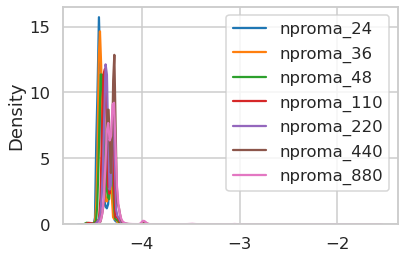

In [38]:
for i, key in enumerate(all_delta_t):
    sns.kdeplot(np.log10(all_delta_t[key]), label=key, color='C'+str(i))
plt.legend()
plt.show()

In [39]:
nproma_df = pd.DataFrame(columns=['nproma', 'mean', 'median', 'max', 'min', 'std'])
for i, key in enumerate(all_delta_t):
    print(key)
    if len(all_delta_t[key]) == 0:
        continue
    new_df = pd.DataFrame(dict(nproma=key.split('_')[1], 
                               mean=np.mean(all_delta_t[key]),
                               median=np.median(all_delta_t[key]),
                               max=np.max(all_delta_t[key]),
                               min=np.min(all_delta_t[key]),
                               std=np.std(all_delta_t[key])), index=[i])
    nproma_df = pd.concat([nproma_df, new_df])

nproma_24
nproma_36
nproma_48
nproma_110
nproma_220
nproma_440
nproma_880


In [40]:
nproma_df

,nproma,mean,median,max,min,std
0,24,0.00004,0.000037,0.010196,0.000023,0.000028
1,36,0.000041,0.000038,0.0062,0.000025,0.000036
2,48,0.000042,0.00004,0.005823,0.000025,0.000038
3,110,0.000045,0.000043,0.026592,0.000026,0.000098
4,220,0.000048,0.000044,0.012487,0.000027,0.000096
5,440,0.000054,0.00005,0.006673,0.000036,0.000133
6,880,0.000062,0.00005,0.025596,0.000036,0.000278


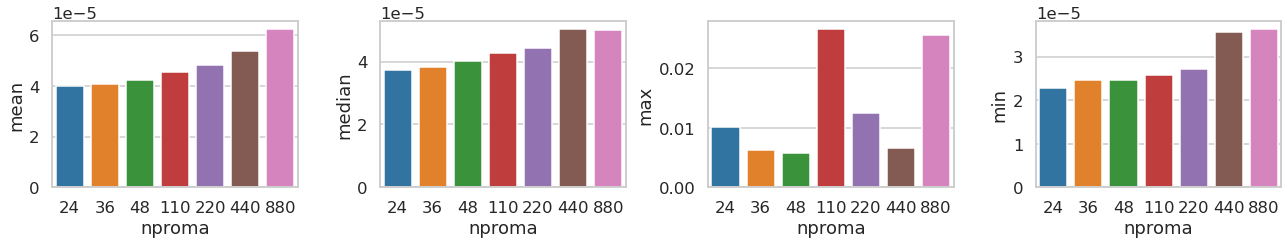

In [41]:
fig, ax = plt.subplots(1, 4, figsize=(18, 3.5))
for i, op in enumerate(['mean', 'median', 'max', 'min']):
    sns.barplot(data=nproma_df, x='nproma', y=op, ax=ax[i])
    #ax[i].hlines(df['mean'].sum(), 0, 10)
fig.tight_layout()

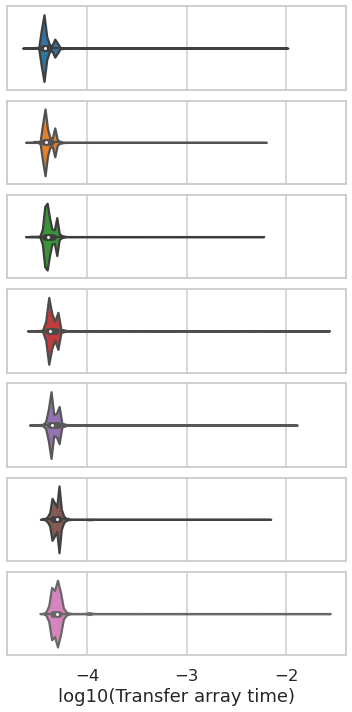

In [42]:
fig, ax = plt.subplots(len(all_delta_t.keys()), 1, sharex=True, sharey=True, figsize=(5, 10))

for i, key in enumerate(all_delta_t):
    sns.violinplot(x=np.log10(all_delta_t[key]), ax=ax[i], color='C'+str(i))
    
ax[-1].set_xlabel('log10(Transfer array time)')
fig.tight_layout()

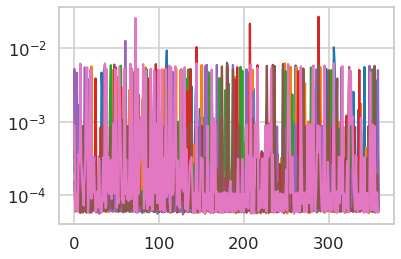

In [43]:
for i, key in enumerate(all_delta_t):
    new_delta_t = np.array(copy.copy(all_delta_t[key])).reshape(-1, 69, 360)
    plt.semilogy(np.max(new_delta_t, axis=(0, 1)))
    

In [44]:
sparse_delta_t = np.array(copy.copy(delta_t))
sparse_delta_t = sparse_delta_t.reshape(-1, 360)

<ipython-input-45-e951d773a669>:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


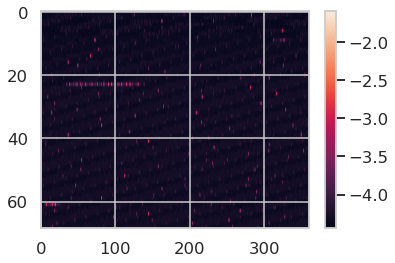

In [45]:
plt.imshow(np.log10(sparse_delta_t), aspect='auto')
plt.colorbar()

plt.show()

In [46]:
df['mean'].sum()

0.000393265932454376

In [47]:
nproma_df

,nproma,mean,median,max,min,std
0,24,0.00004,0.000037,0.010196,0.000023,0.000028
1,36,0.000041,0.000038,0.0062,0.000025,0.000036
2,48,0.000042,0.00004,0.005823,0.000025,0.000038
3,110,0.000045,0.000043,0.026592,0.000026,0.000098
4,220,0.000048,0.000044,0.012487,0.000027,0.000096
5,440,0.000054,0.00005,0.006673,0.000036,0.000133
6,880,0.000062,0.00005,0.025596,0.000036,0.000278


In [48]:
nproma_df[nproma_df['nproma'] == '48']['mean'].values[0]

4.231340177345538e-05

<AxesSubplot:xlabel='source', ylabel='time'>

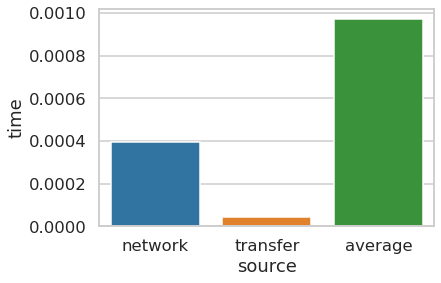

In [49]:
plot_df = pd.DataFrame(dict(source=['network', 'transfer', 'average'], 
                            time=[df['mean'].sum(), nproma_df[nproma_df['nproma'] == '48']['mean'].values[0], 
                            0.00097]))
sns.barplot(data=plot_df, x='source', y='time')

In [50]:
plot_df = pd.DataFrame(dict(time=[df['mean'].sum(), nproma_df[nproma_df['nproma'] == '48']['mean'].values[0]]), index=['network', 'transfer'], )

<AxesSubplot:>

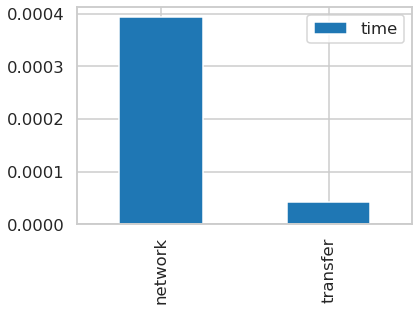

In [51]:
plot_df.plot(kind='bar', stacked=True)

In [52]:
%%time
all_delta_t_full = {}

for idty in ['ROUTINETIME', 'TRANSFERTIME', 'INFERENCETIME']:
    print(idty)
    delta_t = []
    with open(f'/work/ka1176/caroline/gitlab/icon-aes/experiments/special_logs/log_cffi_nproma_44_{idty}DEBUG') as f:
        line = f.readline()
        while line:
            if 'Transfer arrays delta' in line:
                tt = float(re.findall(r'[-+]?\d*\.\d+', line)[0])
                delta_t.append(tt)   
            elif 'Python routine delta' in line:
                tt = float(re.findall(r'[-+]?\d*\.\d+', line)[0])
                delta_t.append(tt)
            if 'L phys_2mom_warmrain' in line:
                print(line)
            line = f.readline()
    all_delta_t_full[idty] = delta_t

ROUTINETIME
0:               L phys_2mom_warmrain       496800        0.00004s       0.00050s       0.64179s        246.992         246.992         246.992    

TRANSFERTIME
0:               L phys_2mom_warmrain       496800        0.00005s       0.00050s       0.19988s        247.893         247.893         247.893    

INFERENCETIME
0:               L phys_2mom_warmrain       496800        0.00004s       0.00050s       0.32657s        247.727         247.727         247.727    

CPU times: user 42.6 s, sys: 5.86 s, total: 48.5 s
Wall time: 1min 52s


In [53]:
t_ref = 0.0005

print(f'Fortran average routine time {t_ref:.3e} s')

key = 'ROUTINETIME'
print(f'{key:16s} {np.mean(all_delta_t_full[key]):.3e} s ({np.mean(all_delta_t_full[key])/t_ref*100:.2f} %)')
key = 'TRANSFERTIME'
print(f'  {key:20s} {np.mean(all_delta_t_full[key]):.3e} s ({np.mean(all_delta_t_full[key])/t_ref*100:.2f} %)')
key = 'INFERENCETIME'
print(f'  {key:20s} {np.mean(all_delta_t_full[key]):.3e} s ({np.mean(all_delta_t_full[key])/t_ref*100:.2f} %)')

Fortran average routine time 5.000e-04 s
ROUTINETIME      4.782e-04 s (95.64 %)
  TRANSFERTIME         4.218e-05 s (8.44 %)
  INFERENCETIME        4.356e-04 s (87.12 %)


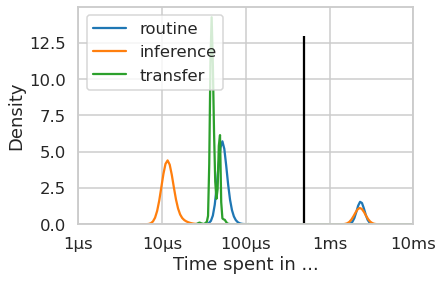

In [54]:
sns.kdeplot(np.log10(all_delta_t_full['ROUTINETIME']), label='routine')
sns.kdeplot(np.log10(all_delta_t_full['INFERENCETIME']), label='inference')
sns.kdeplot(np.log10(all_delta_t_full['TRANSFERTIME']), label='transfer')
ax=plt.gca()
ax.vlines(np.log10(t_ref), 0, 13, color='black')
ax.set_xlabel('Time spent in ...')
ax.legend(loc=2)
ax.set_xlim(-6, -2)
ax.set_xticks([-6, -5, -4, -3, -2])
ax.set_xticklabels(['1µs', '10µs', '100µs', '1ms', '10ms'])
plt.show()

In [55]:
tt = np.asarray(all_delta_t_full['INFERENCETIME'])

Fraction of calls where inference is actually executed (non-zero input moments)

In [56]:
np.sum(tt > 1e-3) / len(tt)

0.18244565217391304

This is the factor by which the inference is slower when it is called from within Fortran, as opposed to the standalone mode

In [57]:
1/(df['mean'].sum() / np.mean( np.asarray(all_delta_t_full['ROUTINETIME'])[tt>5e-4]))

6.049267921366932